# Integrantes:
- Nicolás Mejía - 201314597
- Pablo Ruíz - 201227891
- Germán Carvajal - 201313516

# Handout 2 - MLANDPP: Riesgo Default

La base estudiada en este problema se compone de registros de 50,000 transacciones de _mobile money_. Esta información puede ser relevante para las etapas de inclusión de personas a los créditos bancarios, puesto que es la información más relevante que pueden tener los bancos de personas que no hacen uso de sus servicios.

En este caso, a través de la variable _default_ que determina si el cliente en cuestión realizó o no el pago de sus préstamos móviles, buscamos diseñar un modelo de clasificación que permita, a través de la información disponible, predecir la posibilidad de que las personas tengan un buen desempeño frente a sus préstamos móviles (que cumplan con sus pagos), y de esta forma poder caracterizar a éstos como potenciales clientes para recibir un crédito bancario.

Desde el punto de políticas públicas, estudiar potenciales predictores de la confiabilidad del pago de los compromisos financieros de de las personas es de vital importancia para promover el acceso al crédito, uno de los pilares fundamentales de la relacion entre finanzas y el crecimiento de largo plazo. El acceso al crédito tiene una gran utilidad debido a la multiplicidad de usos que pueden darse a los recursos recibidos y los emprendimientos y mejoras econímicas que se pueden derivar de ellos.

En este orden de ideas, inicialmente realizaremos un análisis de la información disponible, para posteriormente proponer el o los modelos que resulten ser de mayor utilidad para el objetivo propuesto.

## Lectura de los datos

Para facilitar la lectura del código y las referencias a las librerias y funciones utilizadas durante el código, a continuación se agrupan todas las funciones y procesos importados para la ejecución del notebook.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from livelossplot import PlotLossesKeras
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline

Debido a que la variable de interés, así como la variable de género, no son numéricas, se generan variables dummy para cada nivel de cada variable, generando 2 binarias para la variable default y 3 binarias para la variable de genero. 

Con el fin de evitar problemas de colinealidad en los modelos que entrenaremos posteriormente, se elimina la variable "Paid",
para quedarnos unicamente con la variable de interes "Default" Y se elimina uno de los niveles de la variable genero "OTHER" 
quedandonos así con las variables binarias "Male" y "Female"

In [9]:
momo=pd.read_csv('momo_z.csv')
momo=pd.concat([momo,pd.get_dummies(momo['default']),pd.get_dummies(momo['gender'])],axis=1)
y=momo['Default']
x=momo.drop(['Default','default','gender','Paid','OTHER'],axis=1)
momo=momo.drop(['gender','Paid','OTHER'],axis=1)

Separamos la base de datos en sets de entrenamiento (90% de los datos) y test (10% de los datos). La base de test será utilizada unicamente como una última instancia de evaluación para cada uno de los modelos que se entrenarán para la tarea de clasificación.

In [10]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=123)

## Exploración de la base de datos

En primer lugar, calculamos para cada una de las 22 variables disponibles en la base de datos las principales estadísticas descriptivas, con el fin de explorar su comportamiento y darnos una idea preliminar de la distribución y naturaleza de cada una de las variables.

In [6]:
momo.drop('default',axis=1).describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
send_amt,50000.0,0.000,1.000,-0.337,-0.300,-0.236,-0.062,41.582
send_qty,50000.0,0.000,1.000,-0.641,-0.501,-0.302,0.077,23.324
send_dgr,50000.0,-0.000,1.000,-0.783,-0.514,-0.299,0.185,29.548
received_amt,50000.0,-0.000,1.000,-0.420,-0.352,-0.254,-0.024,36.132
received_qty,50000.0,0.000,1.000,-0.806,-0.557,-0.272,0.227,58.559
received_dgr,50000.0,0.000,1.000,-0.993,-0.612,-0.231,0.245,38.883
deposit_amt,50000.0,-0.000,1.000,-0.335,-0.287,-0.219,-0.055,39.802
deposit_qty,50000.0,0.000,1.000,-0.709,-0.504,-0.271,0.109,28.545
deposity_dgr,50000.0,0.000,1.000,-1.133,-0.669,-0.322,0.258,11.385
withdraw_amt,50000.0,0.000,1.000,-0.355,-0.310,-0.221,-0.016,36.886


Se puede observar que las variables presentes en la base de datos han sido estandarizadas previamente con el fin de lograr que todas tuvieran una media de 0 y varianza de 1. Al estar estandarizadas, muy poco se puede interpretar de las demas estadisticas descriptivas, ya que al hacer la transformación, las variables pierden sus valores reales y no existe posibilidad de volver a obtenerlos, imposibilitando la interpretación del mínimo, máximo o alguno de los percentiles.

Después del análisis descriptivo de las variables, se calculan las correlaciones entre pares de variables, incluyendo la relación con la variable objetivo del estudio. Considerando las naturalezas categóricas de la variable dependiente y de algunas caracteristicas se utilizá la medida de correlación de Spearman (rank-correlation)

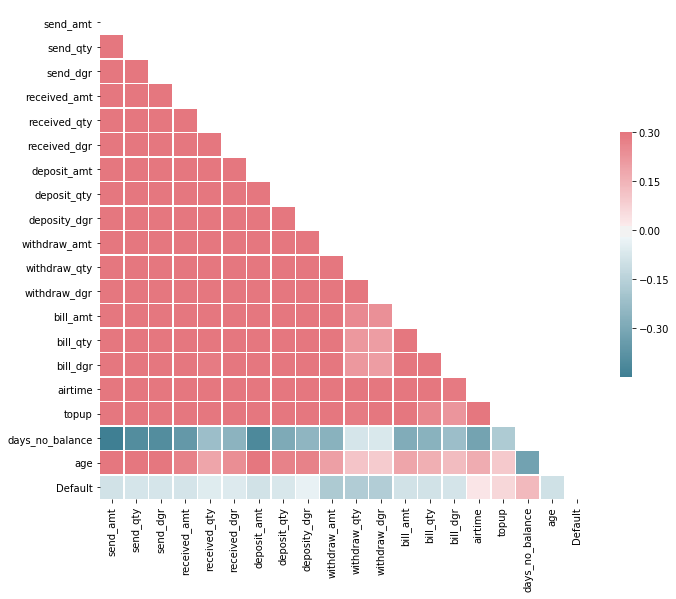

In [7]:
corr = momo.drop(['default','FEMALE','MALE'],axis=1).corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

Se puede observar como ningún par de variables poseen una correlación lo suficientemente alta. Todas las correlaciónes calculadas oscilan entre  0.3 y -0.4 aproximadamente. Es aún mas interesante notar cómo la variable de interés, es aquella que posee las correlaciones mas bajas, que tienden a cero en la mayoria de los casos. Este hallazgo preliminar, da un indicio de que los modelos predictivos pueden no posee el mejor de los comportamientos, puesto que ninguna de las variables explicativas posee una fuerte relación con el hecho de hacer o no default.

Después del análisis de correlaciones, se realizan scatter plots para algunos pares de variables e histogramas de cada variable individual, con el fin de observar la distribución bivariada de cada par y una idea preliminar de aquellas variables que puedan resultar las mas relevantes en la división de las clases.

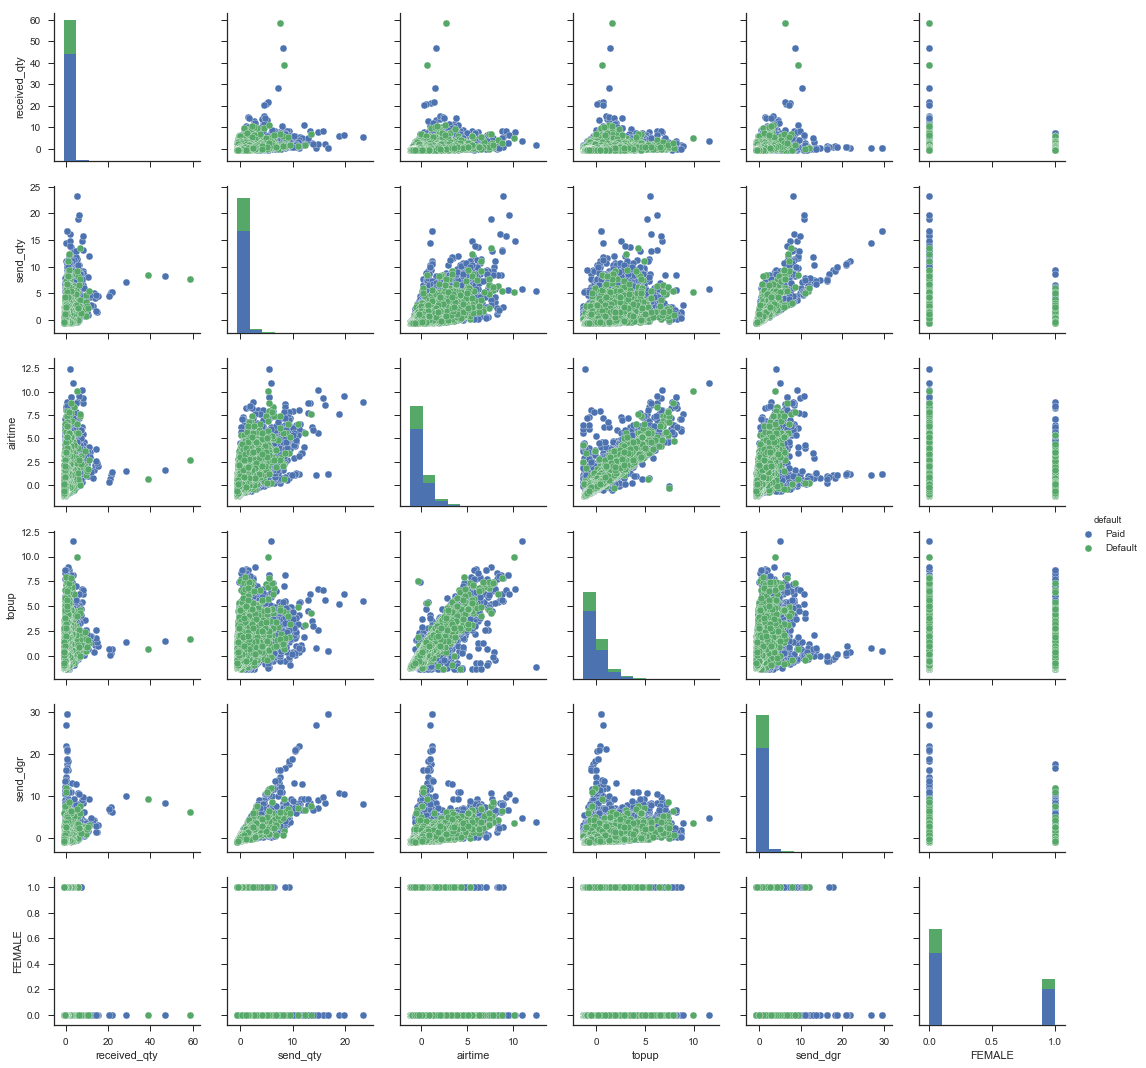

In [8]:
sns.set(style="ticks")
sns.pairplot(momo.iloc[:,[4,1,15,16,2,21,19]].copy(), hue='default')

Los ScatterPlot por pares muestran como cada par de variables posee la misma distribución para ambas clases (Hacer o No DEFAULT). Las gráficas muestran cómo las distribuciones se sobreponen una a la otra, no existe una clara distinción entre las clases para cada variable. Es posible que este comportamiento sea el resultado de la estandarización, que transformó las variables, volviéndolas de medida muy similar, no solo entre las variables, sino entre las clases de interés. Así mismo, puede verse como los histogramas de cada variable estan muy concentrados en el cero, otro resultado de la estandarización a la cual fueron sometidos previo al estudio.

 ### Logit - LASSO

En vista de las hipótesis anteriores proponemos, en rimer lugar, correr una regresión LASSO iterando en los valores de la inversa de la fuerza de regularización (inversa del parámetro de penalización $\lambda$). Sin embargo para este caso proponemos un LASSO  dentro de una regresión Logit, pues se trata de un modelo de clasificación binaria. Al realizar esta regresión esperamos la penalización de las variables que resulten menos relevantes para la clasificación a través de nuestra variable de interés.

La calibración del hiper-parámetro de regularización es evaluada mediante 5-fold cross-validation, utilizando el área bajo la curva ROC como la medida de desempeño de clasificación del algoritmo.

In [9]:
C_s = np.logspace(-10, 5, 10)
scores = []
scores_std = []
for c in C_s:
    logit = LogisticRegression(penalty='l1',random_state=123,verbose=0,C=c)
    score=cross_val_score(logit, x_train, y_train,scoring='roc_auc',cv=5)
    scores.append(score.mean())
    scores_std.append(score.std())

A continuación se construye una gráfica de la medida de desempeño en función de los valores del hiper-parámetro de regularización.

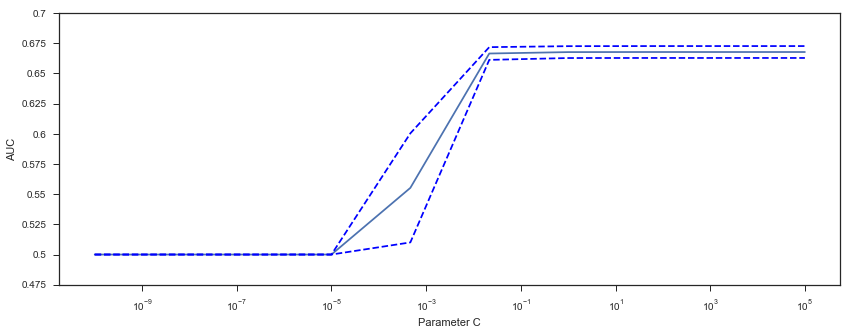

In [10]:
plt.figure(1, figsize=(14, 5))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('AUC')
plt.xlabel('Parameter C')
plt.show()

In [11]:
C_s[scores.index(max(scores))]

100000.0

Encontramos entonces que el máximo valor de la inverza de la fuerza de regularización es $10^4$, que en última instancia corresponde a un valor muy pequeño de penalización. En la gráfica anterior podemos ver que a través de cross validation, bajo los valores más altos del parámetro C se obtienen los mayores valores para el AUC, medida de desempeño escogida para medir el potencial de predicción que tiene cada modelo. Para este valor del parametro de penalización no existe ninguna variable que sea eliminada del modelo. Reduce los coeficientes para aumentar la capacidad predictiva del modelo, pero no logra llevar ninguno a cero, resultando en un modelo con el mismo numero de variables con el que se empezó

In [15]:
logit = LogisticRegression(penalty='l1',random_state=123,verbose=0,C=100000)
logit.fit(x_train,y_train)
y_pred=logit.predict_proba(x_test)[:,1]
print('Test AUC: ',roc_auc_score(y_test,y_pred))

Test AUC:  0.6556243085068547


Ahora, en la evaluación por 5-fold cross-validation se tiene que el desempeño del modelo corresponde a aproximadamente 0.655 de área bajo la curva. Este desempeño es confirmado al aplicar el algortimo de clasifiacción a la base de datos de evaluación (test) la cual no habia sido expuesta al modelo en ningun momento durante el proceso de entrenamiento. Este es un resultado aceptable dada la baja correlación encontrada entre las variables, mas sin embargo aún muy bajo para ser considerado una herramienta confiable.

In [16]:
logit.coef_

array([[-0.16897738,  0.06189017, -0.39062094,  0.07958339,  0.33518622,
        -0.14952264,  0.06295446, -0.12024912,  0.21395736, -0.16094243,
        -0.0630574 , -0.33243968, -1.08694782, -0.0547691 , -0.09132762,
         0.2841421 ,  0.1277134 ,  0.3206096 , -0.12726518, -0.1575028 ,
         0.14086843]])

El modelo resultado con el parametro $\lambda$ sigue conteniendo todas las variables. La regularización resultante disminuye todos los coeficientes, pero ninguno lo lleva hasta cero, resultando en un modelo con el mismo número de variables con las que se inició (21).

### CART

Como paso siguiente, se propone un model basado en árboles para discriminar entre faltar o no al pago de la deuda. En este caso, el hiperparametro del coeficiente de complejidad se encuentra mediante 5-fold cross validation, utilizando el área bajo la curva ROC como metrica de desempeño del algoritmo.

In [13]:
impu=np.logspace(-10,0,10)
scores = []
scores_std = []
for c in impu:
    cart=DecisionTreeClassifier(max_depth=5,max_features=10,random_state=123,min_impurity_decrease=c)
    score=cross_val_score(cart, x_train, y_train,scoring='roc_auc',cv=5)
    scores.append(score.mean())
    scores_std.append(score.std())

A continuación se construye una gráfica de la medida de desempeño en función de los valores del hiper-parámetro de complejidad.

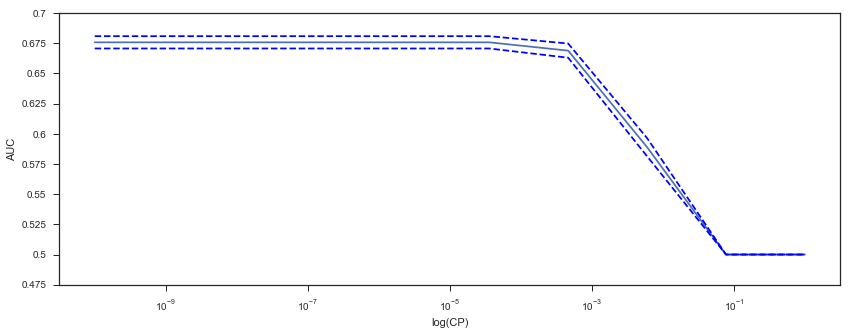

In [14]:
plt.figure(1, figsize=(14, 5))
plt.clf()
plt.semilogx(impu, scores)
plt.semilogx(impu, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(impu, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('AUC')
plt.xlabel('log(CP)')
plt.show()

In [15]:
impu[scores.index(max(scores))]

1e-10

Podemos observar como el parámetro de complejidad que genera el modelo con el mejor desempeño correspone a $10^{-9}$ un valor muy cercano a 0. La gráfica nos muestra, la evolución del area bajo la curva ROC con cambios sobre el hiperparametro. De acuerdo con la validación los valores del parametro de complejidad mas bajos corresponden a valores superiores en desempeño del modelo de clasificación resultante. 

Teniendo el parametro calibrado, se construye el modelo de árboles sobre la base de entrenamiento y se revisa su calidad predictiva con respecto a la base de test.

In [18]:
cart=DecisionTreeClassifier(max_depth=5,max_features=10,random_state=123,min_impurity_decrease=0)
cart.fit(x_train,y_train)
y_pred=cart.predict_proba(x_test)[:,1]
print('Test AUC: ',roc_auc_score(y_test,y_pred))

Test AUC:  0.6753910498183585


El modelo CART resultante posee un area bajo la curva ROC de 0.675, el cual es una ligera mejora sobre el modelo anterior de regresión logística, pero sigue sin ser un desempeño satisfactorio, para ser utilizado como herramienta en el diseño de política pública.

Una de las ventajas que poseen los modelos de árboles de clasificación es su interpretabilidad. En este sentido, y con el fin de obtener mas información acerca del problema y la naturaleza de la interaccion entre las distintas variables que eventualmente llevan a la decisión de una persona de pagar o no su deuda, se calcula la importancia relativa de cada una de las variables utilizadas en el árbol final, asi como el grafo del modelo con el fín de determinar las variables que resultan significativas a la hora de la discriminación de ambas poblaciones.

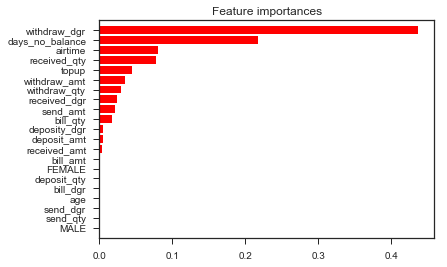

In [68]:
importances = cart.feature_importances_
indices = np.argsort(importances)
plt.figure()
plt.title("Feature importances")
plt.barh(range(x_train.shape[1]), importances[indices], color="r", align="center")
plt.yticks(range(x_train.shape[1]), x_train.columns[indices])
plt.ylim([-1, x_train.shape[1]])
plt.show()

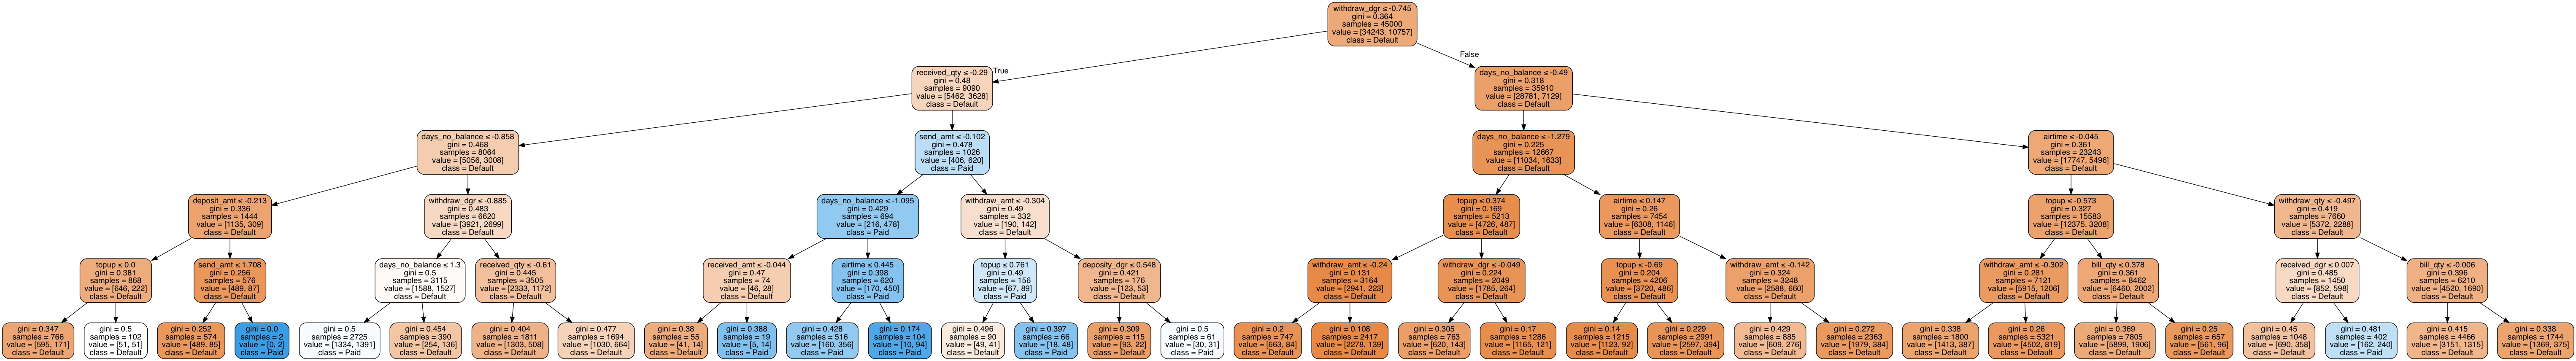

In [70]:
dot_data = StringIO()
export_graphviz(cart, out_file=dot_data, feature_names=x_train.columns,class_names=['Default','Paid'],
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(),unconfined=True)

El análisis de variables dio como resultado "Withdraw" (que representa el convertir una transaccion mobil en dinero físico) y la variable "Days_no_balance" (la cual representa el numero de dias en los cuales el celular del cliente no posee saldo disponible) como las variables que mas influyen a la hora de discriminar entre aquellos clientes que pagaran sus dedudas y los que no. A pesar de la estandarización de la base, este resultado tiene sentido intuitivo, debido al hecho de que estas variables representan los movimientos y la liquidez que posee un cliente en particular, los cuales pueden ser vistos como proxy para la capacidad de responder a sus obligaciones financieras.

### Random Forest

Tenindo el modelo de árboles, se propone un ensemble de los mismos con el fin de mejorar las predicciones y reducir la variabilidad de los resultados, razón por la cual el siguiente modelo a probar sera un Random Forest. En este caso, el hiperparámetro del numero de árboles que se crean para el bosque, se encuentra mediante 5-fold cross validation, utilizando el área bajo la curva ROC como metrica de desempeño del algoritmo.

In [15]:
num=np.arange(20,150,20)
scores = []
scores_std = []
for n in num:
    rf=RandomForestClassifier(n_estimators=n,max_features=5,max_depth=5,n_jobs=2,random_state=123,verbose=0)
    score=cross_val_score(rf, x_train, y_train,scoring='roc_auc',cv=5)
    scores.append(score.mean())
    scores_std.append(score.std())

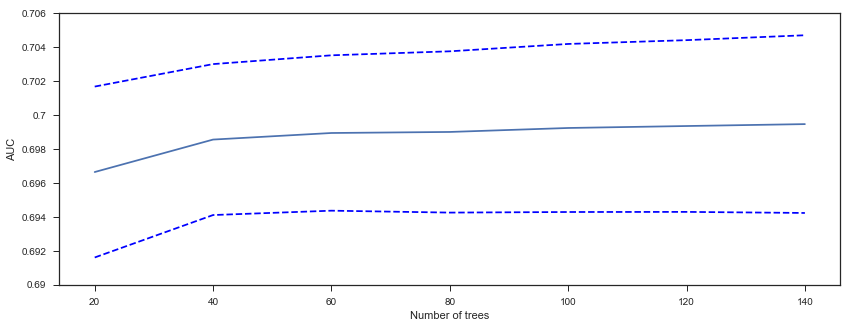

In [16]:
plt.figure(1, figsize=(14, 5))
plt.clf()
plt.plot(num, scores)
plt.plot(num, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(num, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('AUC')
plt.xlabel('Number of trees')
plt.show()

In [17]:
num[scores.index(max(scores))]

140

Podemos observar como el número de árboles a generar que resulta en el modelo con el mejor desempeño correspone a $140$. La gráfica nos muestra, la evolución del area bajo la curva ROC con cambios sobre el hiperparametro. De acuerdo con la validación los valores del parametro número de árboles mas altos corresponden a valores superiores en desempeño del modelo de clasificación resultante. 

Teniendo el parametro calibrado, se construye el modelo de árboles sobre la base de entrenamiento y se revisa su calidad predictiva con respecto a la base de test.

In [11]:
rf=RandomForestClassifier(n_estimators=140,max_features=5,max_depth=5,n_jobs=2,random_state=123,verbose=0)
rf.fit(x_train,y_train)
y_pred=rf.predict_proba(x_test)[:,1]
print('Test AUC: ',roc_auc_score(y_test,y_pred))

Test AUC:  0.6939369923872551


El modelo RF resultante posee un area bajo la curva ROC de 0.694, el cual es una ligera mejora sobre el modelo anterior de árboles de clasificación y regresión logística. Aún así, no es un desempeño satisfactorio, para ser utilizado como herramienta en el diseño de política pública.

Ya que el modelo de Random Forest posee una mejora en la discriminación de los clientes que pagan o no sus deudas, se quiere revisar las variables que aportan la mejor (y mayor cantidad) de información a la hora de realizar la clasificación más pura. 

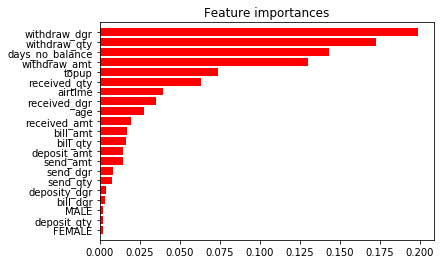

In [12]:
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure()
plt.title("Feature importances")
plt.barh(range(x_train.shape[1]), importances[indices], color="r", align="center")
plt.yticks(range(x_train.shape[1]), x_train.columns[indices])
plt.ylim([-1, x_train.shape[1]])
plt.show()

Para este modelo en particular, se puede ver como las variables referentes al retiro de fondos toman mayor importancia, siendo 3 de las 4 mas importantes. la variable restante en el top 4 es, de la misma manera que en el árbol, el número de días en los cuales la cuenta no contaba con saldo disponible para realizar transacciones.

### Red neuronal

Habiendo entrenado un modelo logit-regularizado como la herramienta estadística básica de clasificación, un árbol de clasificación y un modelo ensamblado de random forest cuyos desempeños no han superado un área bajo la curva de 0.7, se decide explorar los modelos de redes neuronales para explorar potenciales relaciones no lineales e interacciones entre las variables que no se hayan considerado hasta el momento. Dada la naturaleza de las redes neuronales y sus tiempos de calibración, se considera ineficiente computacionalmente aplicar evaluación 5-fold como en los casos anteriores, por lo cual se utilizará la division de entrenamiento-validación como la estrategia de evaluación.

In [19]:
x_entrena,x_valid,y_entrena,y_valid=train_test_split(x_train,y_train,test_size=0.4,random_state=123)

En un incio se proponía utilizar un modelo de deep-learning como herramienta de clasificación, sin embargo la baja complejidad de los datos induce rápidamente un efecto de gradient-fade que no permité el aprendizaje de los parámetros de la red. En consecuencia, el modelo finalmente entrenado es una red neuronal de 1 capa oculta y una arquitectura (3,2,1) sobre las neuronas del modelo. Las funciones de activación se han especificado en todos los casos como sigmoides y se ha aumentado la tasa de aprendizaje del algotimo de stochastic-gradient-descent para evitar el fenomeno de fading.

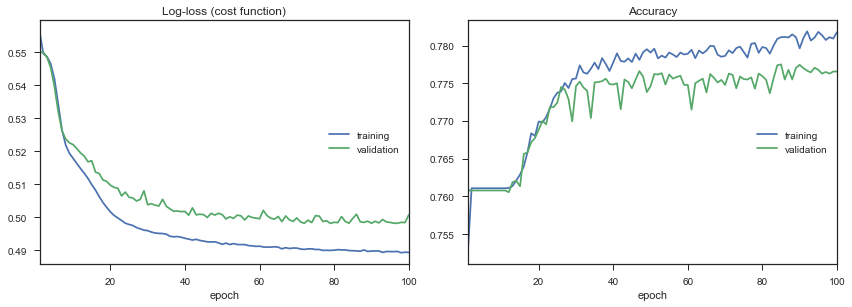

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 66        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
None
Test score: 0.5111465509414673
Test accuracy: 0.7672


In [20]:
np.random.seed(1)
tf.set_random_seed(123)
sgd=SGD(lr=0.1)
model=Sequential()
model.add(Dense(3,activation='sigmoid',input_shape=(21,)))
model.add(Dense(2,activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
history=model.fit(x_entrena,y_entrena,epochs=100,verbose=0,validation_data=(x_valid,y_valid),callbacks=[PlotLossesKeras()])
score=model.evaluate(x_test,y_test,verbose=0)
print(model.summary())
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Como se puede apreciar, a partir de la época 40 se presenta una estabilización del _accuracy_ del modelo y de la funcion de pérdida definida sobre la base de entrenamiento, y asimismo sobre los datos de validación.

In [21]:
y_pred=model.predict(x_test)
roc_auc_score(y_test,y_pred)

0.7048118067392889

Con el modelo calibrado, finalmente se obtiene un área bajo la curva ROC de 0.7048 que es el mayor valor obtenido hasta ahora, pero con un aumento de ≈0.0492 sobre el modelo básico de regresión logística. Un valor que resulta inferior a lo esperado dado el aumento en la complejidad del algoritmo de clasificación.

### Boosting

Tras entrenar modelos de clasificación clásicos, de sub-división del espacio y de aprendizaje profundo con resultados no completamente satisfactorios, se procede a considerar otro paradigma de machine-learning. Se utilizará el paradigma de aprendizaje "lento" con un algoritmo ensamblado de boosting con árboles de decisión. El hiper-parámetro de de regularización en este caso corresponde al número de estimadores individuales que se construirán para el modelo. Se explorarán desde 50 a 150 árboles individuales en el ensamblaje.

In [22]:
trees=np.arange(50,150,10)
scores = []
scores_std = []
for n in trees:
    boost=AdaBoostClassifier(n_estimators=n,random_state=123)
    score=cross_val_score(boost, x_train, y_train,scoring='roc_auc',cv=5,n_jobs=-1)
    scores.append(score.mean())
    scores_std.append(score.std())

Como se puede apreciar en la siguiente gráfica, el número de árboles no influye significativamente en el área bajo la curva evaluada por 5-fold cross-validation. La medida de desempeño se mantiene aproximadamente constante a lo largo de todo el espacio de exploración de hiper-parámetros.

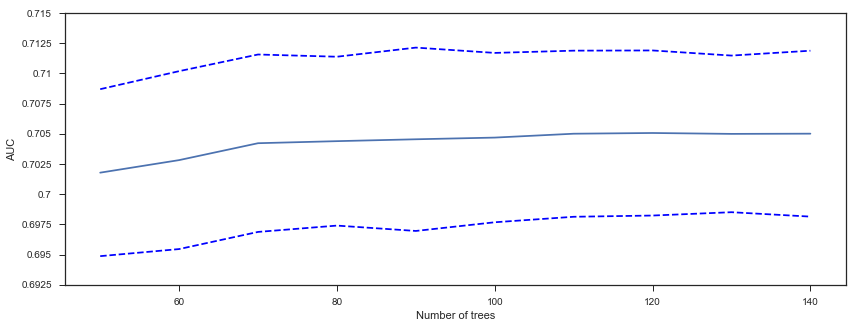

In [23]:
plt.figure(1, figsize=(14, 5))
plt.clf()
plt.plot(trees, scores)
plt.plot(trees, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(trees, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('AUC')
plt.xlabel('Number of trees')
plt.show()

In [24]:
trees[scores.index(max(scores))]

120

Sin embargo, finalmente el número óptimo de estimadores individuales para el paradigma de aprendizaje "lento" se encuentra sobre 120, el cual arroja un valor de área bajo la curva por cross-validation de 0.705.

In [13]:
boost=AdaBoostClassifier(n_estimators=120,random_state=123)
boost.fit(x_train,y_train)
y_pred=boost.predict_proba(x_test)[:,1]
print('Test AUC: ',roc_auc_score(y_test,y_pred))

Test AUC:  0.7034678140203744


Al evaluar el estimador con la base de datos aislada de prueba, se encuentra un valor de AUC de 0.7034 que es muy cercano al obtenido por el modelo más complejo de red neuronal.

Así, con cada mejora en los modelos, indagamos acerca de la nueva información que esto nos puede traer acerca del problema. Para esto calculamos la importancia de las variables para el meta-algotirmo y poder compararlas con aquellas que los modelos anteriores entregaban como las de mayor importancia.

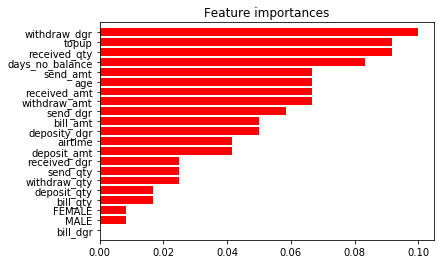

In [14]:
importances = boost.feature_importances_
indices = np.argsort(importances)
plt.figure()
plt.title("Feature importances")
plt.barh(range(x_train.shape[1]), importances[indices], color="r", align="center")
plt.yticks(range(x_train.shape[1]), x_train.columns[indices])
plt.ylim([-1, x_train.shape[1]])
plt.show()

El modelo construido por Boosting, entrega variables ya identificadas (Withdraw_dgr y Days_no_balance) entre las cuatro mas importantes, pero nos muestra variables que no habian sido identificadas en ninguno de los modelos anteriores, como "TopUp" que representa la cantidad de dinero utilizada para generar saldo en el celular y "Recived_qty" que representa la cantidad de transacciones que involucran al cliente en las cuales recivio translados de dinero. Esta última varaiable, en particular, puede ser vista como un representante de la cantidad de dinero o liquidez que posee una persona y por tanto tiene sentido que este realcionada (o sea de importancia) a a hora de encontrar si una persona pagara o no sus obligaciones

### PCA and Boosting

Motivados por el desempeño del meta-algoritmo ensamblado de boosting con árboles de clasificación comparado con las demas estrategias de clasificación exploradas a lo largo del documento, se decide explorar nuevas modificaciones sobre dicho modelo. Para tal objetivo, se aplica la técnica de reducción de dimensionalidad de por componentes principales, encontrandose que con 9 componentes es posible explicar el 90% de la variabilidad agregada de las 21 caracteristicas individuales contenidas en la base de datos original.

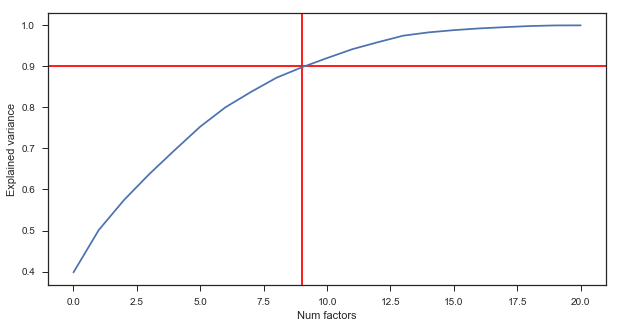

In [26]:
pca=PCA()
pca.fit(x_train)
plt.figure(1, figsize=(10, 5))
plt.xlabel('Num factors')
plt.ylabel('Explained variance')
plt.axhline(y=0.9,color='red')
plt.axvline(x=9,color='red')
plt.plot(np.cumsum(pca.explained_variance_ratio_))

Utilizando dichas 9 primeras componentes principales, se calibra nuevamente el número óptimo de estimadores individuales que se incluirán dentro del meta-algoritmo ensablado. Nuevamente se utiliza la evaluación por 5-fold cross-validation para determinar el valor apropiado para el hiper-parámetro.

In [27]:
pcaT=PCA(9)
x_transformed=pcaT.fit_transform(x_train)
trees=np.arange(50,150,10)
scores = []
scores_std = []
for n in trees:
    boostPCA=AdaBoostClassifier(n_estimators=n,random_state=123)
    score=cross_val_score(boostPCA, x_transformed, y_train,scoring='roc_auc',cv=5,n_jobs=-1)
    scores.append(score.mean())
    scores_std.append(score.std())

Nuevamente, de forma similiar al modelo de boosting con las variables individuales el comportamiento de la medida de desempeño se mantiene aproximadamente constante sobre el conjunto de valores explorado, más sin embargo en este caso es notable que existe una diferencia estadísticamente significativa entre el desempeño con 50 y 140 árboles.

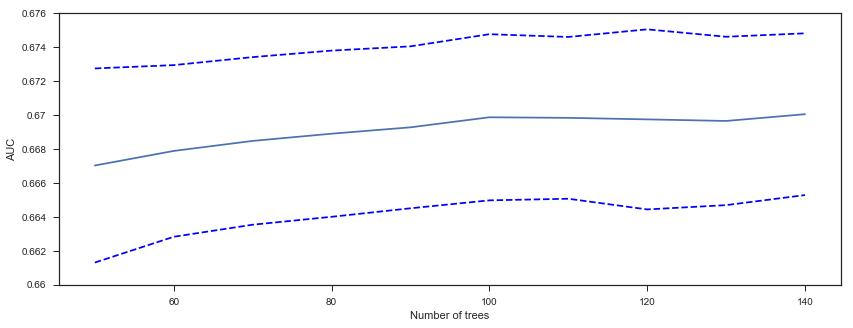

In [28]:
plt.figure(1, figsize=(14, 5))
plt.clf()
plt.plot(trees, scores)
plt.plot(trees, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(trees, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('AUC')
plt.xlabel('Number of trees')
plt.show()

In [29]:
trees[scores.index(max(scores))]

140

Finalmente, el mejor valor para el hiper-parámetro corresponde a 140 estimadores que arrojan un valor de AUC de aproximadamente 0.67.

In [30]:
boostPCA=AdaBoostClassifier(n_estimators=140,random_state=123)
boostPCA.fit(x_transformed,y_train)
y_pred=boostPCA.predict_proba(pcaT.transform(x_test))[:,1]
print('Test AUC: ',roc_auc_score(y_test,y_pred))

Test AUC:  0.7033395851598179


Al aplicar esta estimador calibrado sobre la muestra de prueba, se obtiene un AUC de 0.7033 que se encuentra bajo el desempeño de la red neuronal y el boosting con las variables originales, pero es aun aceptable considerando que este modelo incluye menos de la mitad de varibles indipendientes en comparación a las otras dos estrategias.

### Conclusiones

Teniendo en cuenta los modelos estudiados, todos llegan a la conclusión que uno de los fundamentales en el default de una persona con acceso a dinero móvil son las variables asociadas a las transacciones (especificamente de retiro de dinero), asi como la cantidad de tiempo en que la cuenta posee un balance de 0 (es decir, no tiene fondos disponibles para efectuar movimientos y transacciones en el sistema bancario), las cuales pueden ser vistas como proxys de la liquiedz o capacidad de pago de un individuo.

El dinero movíl surge como una alternativa a las cuentas bancarias tradicionales y funciona como metodo de profundización financiera en lugares donde la educación en temas bancarios de la población es muy limitada. debido a su simpleza y facilidad de uso, la mayoria de la población de el sitio en particular puede hacer uso de esta, actuando como canal para su introduccion al sistema financiero que no solo fomenta la actividad economica (debido a que facilita el intercambio de recursos) sino que puede resultar el punto de partida para el aumento de la educacion financiera y el involucramiento de la población en el sector.

Sin embargo, segun el análisis realizado, los datos obtenidos de transacciones de dinero móvil, pueden resultar no siendo el mejor estimador de la calificación crediticia de un individuo. Aunque en modelos de Redes neuronales, se lograron porcentajes de acierto cercanos al 80%, en ninguno de los modelos construidos se logro un area bajo la curva ROC superior a 0.7 en el conjunto de datos de evaluación. Este resultado, que es significativamente mejor que el azar, muestra que aunque existe relacion entre las transacciones moviles y el posterior compromiso crediticio, estas variables por si solas no logran explicar en su totalidad (o almenos en un porcentaje del todo satisfactorio) la decisión de un individuo en incumplir sus obigaciones adquieridas con la entidad financiera.

Como observaciones finales podemos decir que se exploraron una gran variedad de modelos con diferentes enfoques, cuyos resultados tuvieron algún sentido, pero que en última instancia no resultan con un nivel de predictibilidad suficiente. Al no obtener un valor de AUC considerable por encima de 0.705 (resultado de la red neuronal) en ninguno de los modelos realizados, puede pensarse que una de las razones de este desalentador resultado es la estandarización de las variables. Al tener las variables estandarizadas es probable que se hayan perdido aspectos importantes que estas pueden aportar desde su naturaleza original, pero que se pierden una vez son llevadas a la misma dimensionalidad.

La anterior deducción resulta de la aparente cota que se presenta en el 0.7 del potencial de predicción de la información suministrada. Es probable que al implementar alguno de los modelos anteriores con la base de datos original (sin variables estandarizadas) se encuentren resultados más prometedores e incluso de mayor interés, en vista de que se podrían identificar las variables clave que resulten de mayor interés para el estudio y bajo las cuales se pueden entrenar modelos más precisos, que incluso permitan una caracterización de los clientes más completa (a través de la identificación de diferentes tipos de clientes potenciales a través de _clustering_).

